Code by Alaminanik on Github: https://github.com/alaminanik/PCA-Based-Face-Recognition/blob/master/PCA%20Face%20Recognition.ipynb

In [1]:
from matplotlib import pyplot as plt
from matplotlib.image import imread
from PIL import Image
import numpy as np
import os
import sys

In [2]:
#TRAIN_IMG_FOLDER = './Faces - Copy/training/'
#TEST_IMG_FOLDER = './Faces - Copy/testing/'
#TRAIN_IMG_FOLDER = './Faces/training/'
#TEST_IMG_FOLDER = './Faces/testing/'
TRAIN_IMG_FOLDER = './PCA-Based-Face-Recognition/images1/Training images/'
TEST_IMG_FOLDER = './PCA-Based-Face-Recognition/images1/Test/'


train_set_files = os.listdir(TRAIN_IMG_FOLDER)
test_set_files = os.listdir(TEST_IMG_FOLDER)

width  = 128
height = 128

In [3]:
train_id_file = set([f.split('_')[0] for f in train_set_files])
test_id_file = set([f.split('_')[0] for f in train_set_files])
print(train_id_file <= test_id_file)

True


In [4]:
train_image_names = os.listdir(TRAIN_IMG_FOLDER)
training_tensor   = np.ndarray(shape=(len(train_image_names), height*width), dtype=np.float64)
print('Number of training images:', len(train_image_names))

for i in range(len(train_image_names)):
    img = Image.open(TRAIN_IMG_FOLDER + train_image_names[i]).convert('L') # Convert to grayscale
    img = img.resize((width, height))
    training_tensor[i,:] = np.array(img, dtype='float64').flatten()

test_image_names = os.listdir(TEST_IMG_FOLDER)
testing_tensor   = np.ndarray(shape=(len(test_image_names), height*width), dtype=np.float64)
print('Number of test images:', len(test_image_names))

for i in range(len(test_image_names)):
    img = Image.open(TEST_IMG_FOLDER + test_image_names[i]).convert('L')
    img = img.resize((width, height))
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()

Number of training images: 25
Number of test images: 40


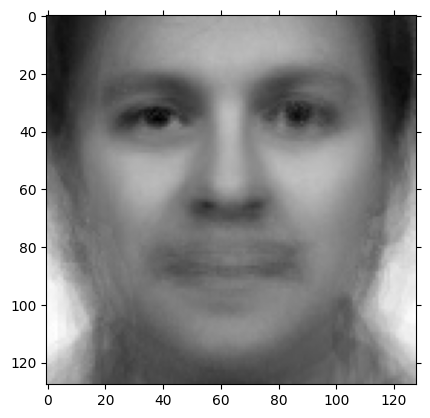

In [5]:
mean_face = np.zeros((1,height*width))

for i in training_tensor:
    mean_face = np.add(mean_face,i)

mean_face = np.divide(mean_face,float(len(train_image_names))).flatten()

plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',
                right='off',left='off', which='both')
plt.show()

In [6]:
normalised_training_tensor = np.ndarray(shape=(len(train_image_names), height*width))

for i in range(len(train_image_names)):
    normalised_training_tensor[i] = np.subtract(training_tensor[i], mean_face)

In [7]:
cov_matrix = np.cov(normalised_training_tensor)
cov_matrix = np.divide(cov_matrix, 165.0)
print('Covariance Matrix Shape:', cov_matrix.shape)

Covariance Matrix Shape: (25, 25)


In [8]:
#eigenvalues and eigenvectors
eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix)
print('eigenvalues.shape: {} eigenvectors.shape: {}'
      .format(eigenvalues.shape, eigenvectors.shape))

eigenvalues.shape: (25,) eigenvectors.shape: (25, 25)


In [9]:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

sorted_ind = sorted(range(eigenvalues.shape[0]), key=lambda k: eigenvalues[k], reverse=True)

eigvalues_sort = eigenvalues[sorted_ind]
eigvectors_sort = eigenvectors[sorted_ind]
train_set_files_sort = np.array(train_set_files)[sorted_ind]

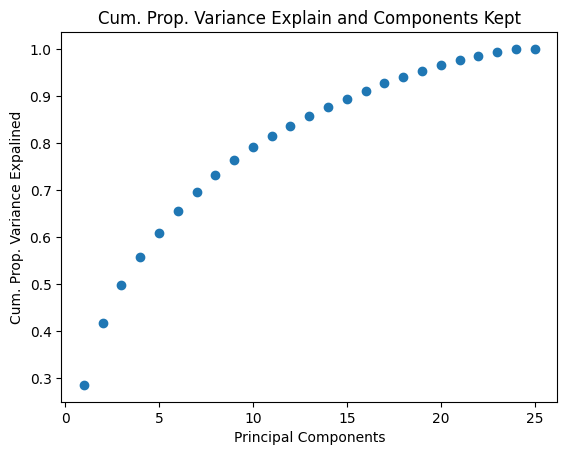

In [10]:
# Show cumulative proportion of varaince with respect to components
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)
#print("Cumulative proportion of variance explained vector: \n%s" %var_comp_sum)

# x-axis for number of principal components kept
num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Cum. Prop. Variance Explain and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')

plt.scatter(num_comp, var_comp_sum)
plt.show()

In [11]:
reduced_data = np.array(eigvectors_sort[:25]).transpose()
print(training_tensor.transpose().shape, reduced_data.shape)

(16384, 25) (25, 25)


In [12]:
# Project the training data onto the reduced space to calculate the eigenfaces
proj_data = np.dot(training_tensor.transpose(), reduced_data)
proj_data = proj_data.transpose()
proj_data.shape

(25, 16384)

In [13]:
#Find the weights for each image in the training set
w = np.array([np.dot(proj_data,i) for i in normalised_training_tensor])
print(w.shape)

(25, 25)


In [25]:
def recogniser(test_image_names, train_image_names, proj_data, w, t0=2e8, prn=False):
    count        = 0
    num_images   = 0
    correct_pred = 0
    result = []
    wts = []
    
    #False match rate (FMR)
    FMR_count = 0
    #False non-match rate (FNMR)
    FNMR_count = 0

    for img in test_image_names:

        #unknown_face = plt.imread(TEST_IMG_FOLDER+img)
        unknown_face = Image.open(TEST_IMG_FOLDER + img).convert('L')
        unknown_face = unknown_face.resize((width, height))
        num_images += 1
        
        unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
        normalised_uface_vector = np.subtract(unknown_face_vector, mean_face)

        w_unknown = np.dot(proj_data, normalised_uface_vector)
        diff  = w - w_unknown
        norms = np.linalg.norm(diff, axis=1)
        index = np.argmin(norms)
        #print("Norms: ", norms, "Index: ", index, end=' ')
        wts.append([count, norms[index]])

        if prn: print('Input:'+'.'.join(img.split('.')[:2]), end='\t')
        count += 1
        
        match = img.split('_')[0] == train_image_names[index].split('_')[0]
        if norms[index] < t0: # It's a face
            if match:
                if prn: print('Matched:' + train_image_names[index], end = '\t')
                correct_pred += 1
                result.append(1)
            else:
                if prn: print('F/Matched:'+ train_image_names[index], end = '\t')
                result.append(0)
                FMR_count += 1
        else:
            if match:
                if prn: print('Unknown face!'+ train_image_names[index], end = '\t')
                FNMR_count +=1
                result.append(1)
                
            else:
                #result.append(1)
                result.append(0)
                pass
                correct_pred += 1

        if prn: print(norms[index], end=' ')
        if prn: print()
            
            
    
    FMR = FMR_count/num_images
    FNMR = FNMR_count/num_images
    
    
    print('Correct predictions: {}/{} = {} \t\t'.format(correct_pred, num_images, correct_pred/num_images), end=' ')
    print('FMR: {} \t'.format(FMR), end=' ')
    print('FNMR: {} \t'.format(FNMR))
    
    return wts, result, correct_pred, num_images, FMR, FNMR
    

wts, result, correct_pred, num_images, FMR, FNMR =recogniser(test_image_names, train_image_names,proj_data, w, t0=1e7, prn=True)

Input:00770_960530_fa.jpg	Matched:00770_960530_fa.jpg	0.0 
Input:00770_960530_fa_a.jpg	40443667.467302464 
Input:00771_941205_fa.jpg	Matched:00771_941205_fa.jpg	0.0 
Input:00771_941205_fb.jpg	Unknown face!00771_941205_fa.jpg	12411902.370116856 
Input:00772_941201_fa.jpg	Matched:00772_941201_fa.jpg	0.0 
Input:00772_941201_fb.jpg	21167349.767040692 
Input:00773_941201_fa.jpg	Matched:00773_941201_fa.jpg	0.0 
Input:00773_941201_fb.jpg	Unknown face!00773_941201_fa.jpg	21385298.893085383 
Input:00775_941205_fa.jpg	Matched:00775_941205_fa.jpg	0.0 
Input:00775_941205_fb.jpg	Matched:00775_941205_fa.jpg	9590985.44902744 
Input:00779_941205_fa.jpg	Matched:00779_941205_fa.jpg	0.0 
Input:00779_941205_fb.jpg	Unknown face!00779_941205_fa.jpg	38922068.40712182 
Input:00781_941205_fa.jpg	Matched:00781_941205_fa.jpg	0.0 
Input:00781_941205_fb.jpg	14277462.667984797 
Input:00787_941205_fa.jpg	Matched:00787_941205_fa.jpg	0.0 
Input:00787_941205_fb.jpg	32827038.49216733 
Input:00794_941205_fa.jpg	Matched:0

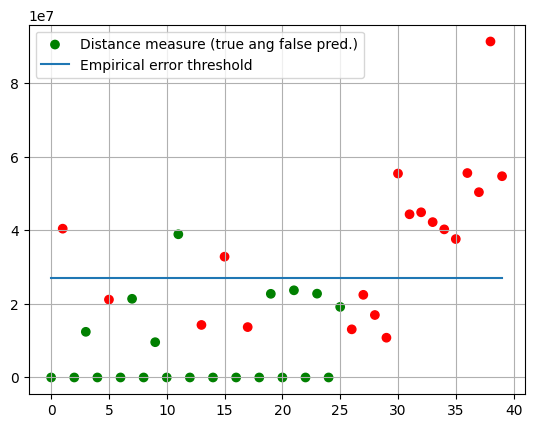

In [26]:
def rg(r):
    if r: return 'g'
    else: return 'r'
cl = [rg(r) for r in result]

x=[x[0] for x in wts]
y=[y[1] for y in wts]
plt.scatter(x,y, color=cl, label = 'Distance measure (true ang false pred.)')

x2=[x[0] for x in wts]
y2=[2.7e7 for y in wts]

plt.plot(x2,y2, label = 'Empirical error threshold')
plt.legend()
plt.grid()

plt.show()

In [27]:
CPR_list, t0_list, FMR_list, FNMR_list = [], [] , [] , []
for t0 in np.linspace(start=0, stop=1e9, num=50):
    print('{:e}'.format(t0), end=' ')
    wts, result, correct_pred, num_images, FMR, FNMR = recogniser(test_image_names, train_image_names,proj_data, w, t0)
    
    CPR_list.append(correct_pred/num_images) 
    t0_list.append(t0)
    FMR_list.append(FMR)
    FNMR_list.append(FNMR)

0.000000e+00 Correct predictions: 19/40 = 0.475 		 FMR: 0.0 	 FNMR: 0.525 	
2.040816e+07 Correct predictions: 30/40 = 0.75 		 FMR: 0.125 	 FNMR: 0.125 	
4.081633e+07 Correct predictions: 29/40 = 0.725 		 FMR: 0.275 	 FNMR: 0.0 	
6.122449e+07 Correct predictions: 22/40 = 0.55 		 FMR: 0.45 	 FNMR: 0.0 	
8.163265e+07 Correct predictions: 22/40 = 0.55 		 FMR: 0.45 	 FNMR: 0.0 	
1.020408e+08 Correct predictions: 21/40 = 0.525 		 FMR: 0.475 	 FNMR: 0.0 	
1.224490e+08 Correct predictions: 21/40 = 0.525 		 FMR: 0.475 	 FNMR: 0.0 	
1.428571e+08 Correct predictions: 21/40 = 0.525 		 FMR: 0.475 	 FNMR: 0.0 	
1.632653e+08 Correct predictions: 21/40 = 0.525 		 FMR: 0.475 	 FNMR: 0.0 	
1.836735e+08 Correct predictions: 21/40 = 0.525 		 FMR: 0.475 	 FNMR: 0.0 	
2.040816e+08 Correct predictions: 21/40 = 0.525 		 FMR: 0.475 	 FNMR: 0.0 	
2.244898e+08 Correct predictions: 21/40 = 0.525 		 FMR: 0.475 	 FNMR: 0.0 	
2.448980e+08 Correct predictions: 21/40 = 0.525 		 FMR: 0.475 	 FNMR: 0.0 	
2.653061e+08 Co

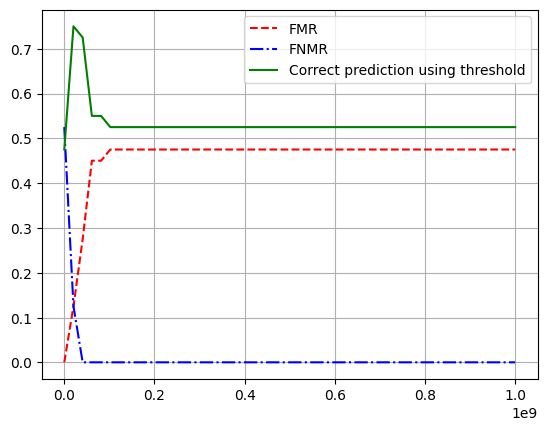

In [28]:
x1=t0_list
y1=FMR_list

x2=t0_list
y2=FNMR_list

x3=t0_list
y3=CPR_list

plt.plot(x1,y1, ls='--', color='r', label='FMR',)
plt.plot(x2,y2, ls='-.', color='b', label='FNMR')
plt.plot(x3,y3, color='g', label='Correct prediction using threshold')

plt.grid()
plt.legend()

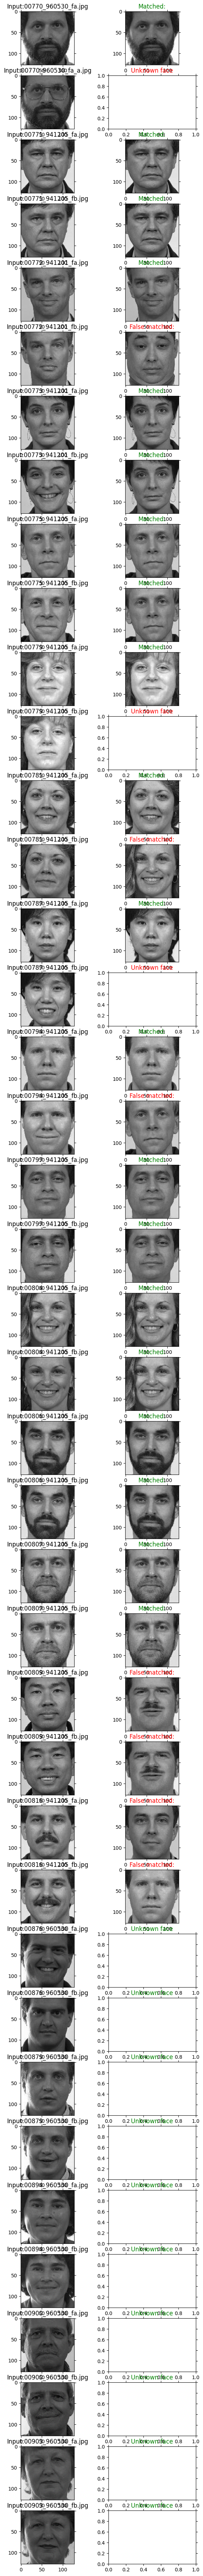

In [29]:
count        = 0
num_images   = 0
correct_pred = 0
def Visualization(img, train_image_names,proj_data,w, t0):
    global count,highest_min,num_images,correct_pred
    #unknown_face        = plt.imread(TEST_IMG_FOLDER+img)
    unknown_face = Image.open(TEST_IMG_FOLDER + img).convert('L')
    unknown_face = unknown_face.resize((width, height))
    num_images          += 1
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    plt.subplot(40,2,1+count)
    plt.imshow(unknown_face, cmap='gray')
    plt.title('Input:'+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1
    
    w_unknown = np.dot(proj_data, normalised_uface_vector)
    diff  = w - w_unknown
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    
   

    
    plt.subplot(40,2,1+count)
    if norms[index] < t0: # It's a face
            
        match = img.split('_')[0] == train_image_names[index].split('_')[0]
        #if img.split('.')[0] == train_image_names[index].split('.')[0]:
        if match:
            #plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='g')
            plt.title('Matched:', color='g')
            plt.imshow(imread(TRAIN_IMG_FOLDER+train_image_names[index]), cmap='gray')
                
            correct_pred += 1
        else:
            #plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='r')
            plt.title('False matched:', color='r')
            plt.imshow(imread(TRAIN_IMG_FOLDER+train_image_names[index]), cmap='gray')
    else:
        #if img.split('.')[0] not in [i.split('.')[0] for i in train_image_names] and img.split('.')[0] != 'apple':
        if img.split('_')[0] not in [i.split('_')[0] for i in train_image_names]:
            plt.title('Unknown face', color='g')
            correct_pred += 1
        else:
            plt.title('Unknown face', color='r')
                
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    plt.subplots_adjust(right=1.2, top=2.5)
   
    count+=1

    
fig = plt.figure(figsize=(5, 30))

test_image_names2 = sorted(test_image_names)
for i in range(len(test_image_names2)):
    Visualization(test_image_names2[i], train_image_names,proj_data,w, t0=2.7e7)

plt.show()